## Маринкин 

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm
from linearmodels.panel import PooledOLS
from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
df = pd.read_csv('IMF_data.csv')
df = df.sort_values(by=['Country','Year']).reset_index(drop=True)

In [4]:
df.head(5)

,Country,Year,investment rate,CPI,Country Code,openness,population density,share of agriculture,share of industry,sec school enr rate,tert school enr rate,Real GDP,population size,Capital stock,Capital stock (foreign),capital account openness,latitude
0,Bahrain,1992,29.917,62.489,419,181.1240,736.7408,0.9099,37.211500,98.4922,16.9525,20178.5246,0.522748,400.888614,63.768180,2.333585,25.930414
1,Bahrain,1993,22.341,64.113,419,164.6039,755.2254,0.8514,37.945000,101.8406,17.5538,22218.0606,0.535692,374.755569,62.513635,2.333585,25.930414
2,Bahrain,1994,24.749,66.676,419,155.1782,774.0606,0.8603,37.425000,105.1617,16.7697,21623.2348,0.549151,398.903023,66.039560,2.333585,25.930414
3,Bahrain,1995,21.287,68.770,419,152.4643,793.9394,0.8629,39.947600,106.1284,16.5609,21910.3403,0.563730,401.885125,59.472894,2.333585,25.930414
4,Bahrain,1996,21.883,68.642,419,164.1154,815.0225,0.4573,43.860286,104.2143,17.6057,22220.7827,0.579855,399.606012,56.239560,1.263433,25.930414


1. Оцените несколько моделей: обычным МНК (pooled), однонаправленную модель с
фиксированными эффектами по странам, двунаправленныю модель с фиксированными эффектами по странам и годам, однонаправленную модель со случайными эффектами по странам. Все модели выведите в одной таблице (например. с помощью
stargazer). Зависимая переменная – темп роста ВВП, регрессоры – наличие программы МВФ и контрольные переменные (covariates из таблицы 1 стр. 15 статьи, хотя
бы некоторые из них)

### Расчитаем темпы роста ввп на душу населения для каждой страны 

In [5]:
df['gdp change'] = df.groupby('Country')['Real GDP'].pct_change() * 100

In [6]:
df.head(5)

,Country,Year,investment rate,CPI,Country Code,openness,population density,share of agriculture,share of industry,sec school enr rate,tert school enr rate,Real GDP,population size,Capital stock,Capital stock (foreign),capital account openness,latitude,gdp change
0,Bahrain,1992,29.917,62.489,419,181.1240,736.7408,0.9099,37.211500,98.4922,16.9525,20178.5246,0.522748,400.888614,63.768180,2.333585,25.930414,NaN
1,Bahrain,1993,22.341,64.113,419,164.6039,755.2254,0.8514,37.945000,101.8406,17.5538,22218.0606,0.535692,374.755569,62.513635,2.333585,25.930414,10.107459
2,Bahrain,1994,24.749,66.676,419,155.1782,774.0606,0.8603,37.425000,105.1617,16.7697,21623.2348,0.549151,398.903023,66.039560,2.333585,25.930414,-2.677217
3,Bahrain,1995,21.287,68.770,419,152.4643,793.9394,0.8629,39.947600,106.1284,16.5609,21910.3403,0.563730,401.885125,59.472894,2.333585,25.930414,1.327764
4,Bahrain,1996,21.883,68.642,419,164.1154,815.0225,0.4573,43.860286,104.2143,17.6057,22220.7827,0.579855,399.606012,56.239560,1.263433,25.930414,1.416876


### Проставим факты использования программы от МВФ

In [7]:
df.loc[(df['Country']=='Cabo Verde')&(df['Year'].between(2006,2012)), 'imf'] = 1
df.loc[(df['Country']=='Mozambique')&(df['Year'].between(2007,2016)), 'imf'] = 1
df.loc[(df['Country']=='Nigeria')&(df['Year'].between(2005,2007)), 'imf'] = 1
df.loc[(df['Country']=='Rwanda')&(df['Year'].between(2010,2016)), 'imf'] = 1
df.loc[(df['Country']=='Senegal')&(df['Year'].between(2007,2018)), 'imf'] = 1
df.loc[(df['Country']=='Tanzania')&(df['Year'].between(2007,2017)), 'imf'] = 1
df.loc[(df['Country']=='Uganda')&(df['Year'].between(2006,2017)), 'imf'] = 1
df['imf'].fillna(0,inplace=True)
df['imf'] = df['imf'].astype(int)

#### начнем основую часть

In [8]:
# Оставим только ковариаты из первой таблички и уберем latittude, чтобы не мучаться с кучей колонок 
df = df.drop(columns=['CPI','Country Code','population size','Capital stock','Capital stock (foreign)','capital account openness','latitude'])

In [9]:
# Для удобства
df.columns = df.columns.str.replace(' ', '_')

In [10]:
covaraites = list(df.columns)
covaraites.remove('Country')
covaraites.remove('Year')
covaraites.remove('gdp_change')
covaraites.remove('Real_GDP')
covaraites.remove('imf')
covaraites

['investment_rate',
 'openness',
 'population_density',
 'share_of_agriculture',
 'share_of_industry',
 'sec_school_enr_rate',
 'tert_school_enr_rate']

In [11]:
# Уберем первые записи по странам, ведь мы не знаем темп роста ввп в этот момент 
df = df[df['gdp_change'].isna()==False]

In [12]:
data = df.copy()
# Устаноим индексы, это надо для библиотеки по панелям
data = data.set_index(['Country', 'Year'])

In [13]:
# Логарифмируем плотность населения. Я уверен, что его распределение смещено вправо 
data['population_density'] = np.log(data['population_density'])

In [14]:
data['Intercept'] = 1

# 2.1

## 2.1 1

In [15]:
data.reset_index().drop(columns=['Real_GDP','Intercept']).to_excel("dz5_data.xlsx")

In [16]:
pooled = PooledOLS.from_formula(f"gdp_change ~ 1+ imf+{'+'.join(cov for cov in covaraites)}", data=data)
pooled = pooled.fit()
pooled.summary

Dep. Variable:,gdp_change,R-squared:,0.0929
Estimator:,PooledOLS,R-squared (Between):,0.5682
No. Observations:,989,R-squared (Within):,0.0293
Date:,"Wed, Dec 04 2024",R-squared (Overall):,0.0929
Time:,22:37:08,Log-likelihood,-3460.0
Cov. Estimator:,Unadjusted,,
,,F-statistic:,12.551
Entities:,43,P-value,0.0000
Avg Obs:,23.000,Distribution:,"F(8,980)"
Min Obs:,23.000,,
Max Obs:,23.000,F-statistic (robust):,12.551


In [17]:
fixed = PanelOLS(data['gdp_change'], data[['Intercept']+['imf']+covaraites], entity_effects=True,time_effects=True)
fixed = fixed.fit()
fixed.summary

Dep. Variable:,gdp_change,R-squared:,0.0391
Estimator:,PanelOLS,R-squared (Between):,-6.6766
No. Observations:,989,R-squared (Within):,0.0377
Date:,"Wed, Dec 04 2024",R-squared (Overall):,-0.7549
Time:,22:37:09,Log-likelihood,-3411.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,4.6587
Entities:,43,P-value,0.0000
Avg Obs:,23.000,Distribution:,"F(8,916)"
Min Obs:,23.000,,
Max Obs:,23.000,F-statistic (robust):,4.6587


In [18]:
random = RandomEffects(data['gdp_change'], data[['Intercept']+['imf']+covaraites])
random = random.fit()
random.summary

Dep. Variable:,gdp_change,R-squared:,0.0705
Estimator:,RandomEffects,R-squared (Between):,0.5621
No. Observations:,989,R-squared (Within):,0.0300
Date:,"Wed, Dec 04 2024",R-squared (Overall):,0.0928
Time:,22:37:10,Log-likelihood,-3449.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,9.2951
Entities:,43,P-value,0.0000
Avg Obs:,23.000,Distribution:,"F(8,980)"
Min Obs:,23.000,,
Max Obs:,23.000,F-statistic (robust):,9.2951


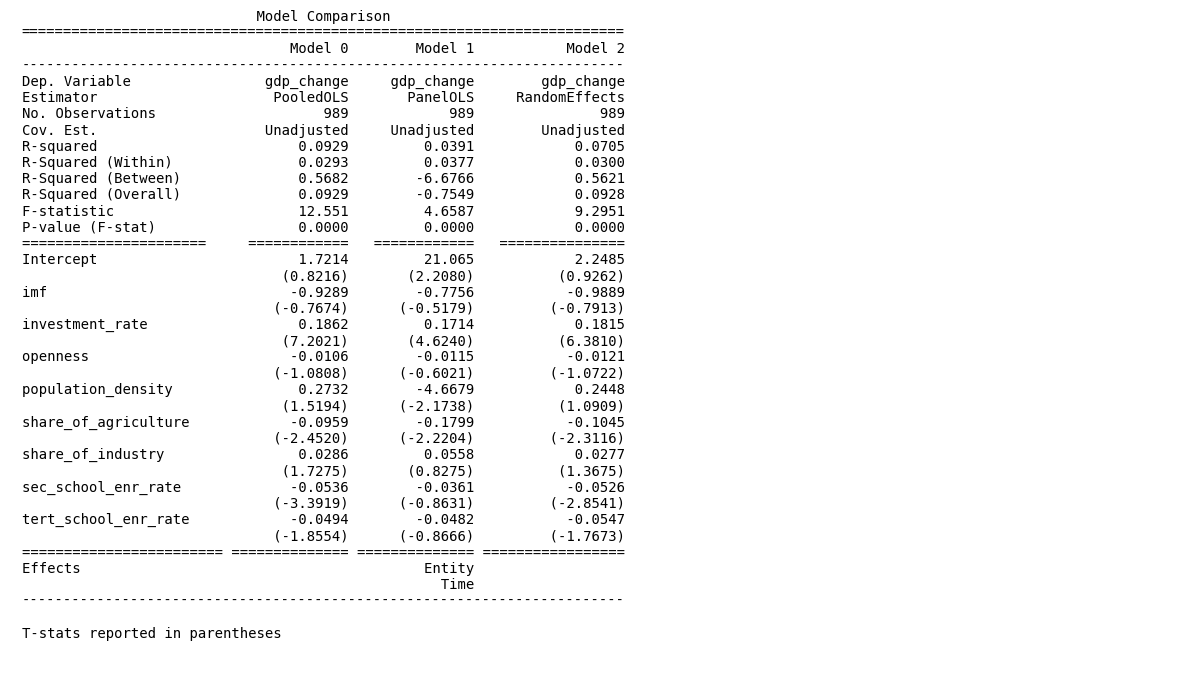

In [19]:
from  linearmodels.panel.results import PanelModelComparison
PanelModelComparison([pooled, fixed, random])
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, PanelModelComparison([pooled, fixed, random]), {'fontsize': 10}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('robust.png')

## 2.1 2

In [20]:
# Общая дисперсия зависимой переменной
total_variance = data['gdp_change'].var()

# Дисперсия, объясняемая фиксированными эффектами стран
country_means = data.groupby('Country')['gdp_change'].mean()
overall_mean = data['gdp_change'].mean()
country_effect_variance = ((country_means - overall_mean)**2).sum() / len(data)

# Дисперсия, объясняемая фиксированными эффектами времени
time_means = data.groupby('Year')['gdp_change'].mean()
time_effect_variance = ((time_means - overall_mean)**2).sum() / len(data)

# Общая доля, объясненная фиксированными эффектами
fixed_effects_share = (country_effect_variance + time_effect_variance) / total_variance
fixed_effects_share

0.0057269177133286294

In [21]:
time_means

Year
1993    0.651652
1994    0.233554
1995    2.523546
1996    3.409290
1997    4.423352
1998    2.452875
1999    1.310439
2000    1.655336
2001    2.734937
2002    2.141340
2003    2.638032
2004    3.724902
2005    2.634507
2006    3.043774
2007    3.453366
2008    2.014430
2009   -1.228523
2010    1.715613
2011    1.227510
2012    4.333717
2013    0.706990
2014    0.689680
2015    1.192708
Name: gdp_change, dtype: float64

## 2.1 3

In [19]:
from scipy import stats
psi = fixed.cov - random.cov
diff = fixed.params - random.params
W = diff.dot(np.linalg.inv(psi)).dot(diff)
dof = random.params.size -1
pvalue = stats.chi2(dof).sf(W)
print("Hausman Test: chisq = {0}, df = {1}, p-value = {2}".format(W, dof, pvalue))
## H0 -- случайные эффекты предпочтительны

Hausman Test: chisq = 8.076853775896694, df = 8, p-value = 0.42599906920592445


### после теста хаусмана я решил сдаться писать тесты вручную и перешел в R

pooltest(pooled,fixed)

F = 1.4682, df1 = 64, df2 = 916, p-value = 0.01153
alternative hypothesis: unstability


plmtest(pooled,effect="individual",type="bp")

data:  gdp_change ~ imf + investment_rate + openness + population_density +  ...

chisq = NaN, df = 1, p-value = NA
alternative hypothesis: significant effects

# 2.2

## 2.2 1

In [78]:
df = pd.read_csv('IMF_data.csv')
df = df.sort_values(by=['Country','Year']).reset_index(drop=True)
df.loc[(df['Country']=='Cabo Verde')&(df['Year'].between(2006,2012)), 'imf'] = 1
df.loc[(df['Country']=='Mozambique')&(df['Year'].between(2007,2016)), 'imf'] = 1
df.loc[(df['Country']=='Nigeria')&(df['Year'].between(2005,2007)), 'imf'] = 1
df.loc[(df['Country']=='Rwanda')&(df['Year'].between(2010,2016)), 'imf'] = 1
df.loc[(df['Country']=='Senegal')&(df['Year'].between(2007,2018)), 'imf'] = 1
df.loc[(df['Country']=='Tanzania')&(df['Year'].between(2007,2017)), 'imf'] = 1
df.loc[(df['Country']=='Uganda')&(df['Year'].between(2006,2017)), 'imf'] = 1
df['imf'].fillna(0,inplace=True)
df['imf'] = df['imf'].astype(int)

In [100]:
from pysyncon import Dataprep, Synth
dataprep = Dataprep(
    foo=df,
    predictors=["Real GDP"],
    predictors_op="mean",
    time_predictors_prior=range(1992, 2007),
    special_predictors=[
        ("share of agriculture", range(1992, 2007), "mean"),
        ("share of industry", [1992, 2007], "mean"),
        ("investment rate", [1992, 2007], "mean"),
        ("population density", [1992, 2007], "mean"),
        
    ],
    dependent="Real GDP",
    unit_variable="Country",
    time_variable="Year",
    treatment_identifier="Cabo Verde",
    controls_identifier=[
        'Bahrain', 'Barbados', 'Belize', 'Bhutan', 'Botswana',
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eritrea',
       'Eswatini', 'Fiji', 'Iran', 'Kiribati', 'Kuwait', 'Lebanon',
       'Libya', 'Marshall Islands', 'Mauritius', 'Micronesia',
       'Montenegro', 'Namibia', 'Oman', 'Palau', 'Qatar', 'Samoa',
       'Saudi Arabia', 'Sudan', 'Suriname', 'Syria', 'The Bahamas',
       'Timor-Leste', 'Tonga', 'Trinidad and Tobago', 'Turkmenistan',
       'Tuvalu', 'United Arab Emirates', 'Vanuatu'
    ],
    time_optimize_ssr=range(1992, 2007),
)

In [101]:
synth_train = Synth()
synth_train.fit(dataprep=dataprep)
synth = Synth()
synth.fit(dataprep=dataprep, custom_V=synth_train.V)

weights = synth.weights()
weights[weights>0]

Bhutan    0.791
Iran      0.140
Palau     0.069
Name: weights, dtype: float64

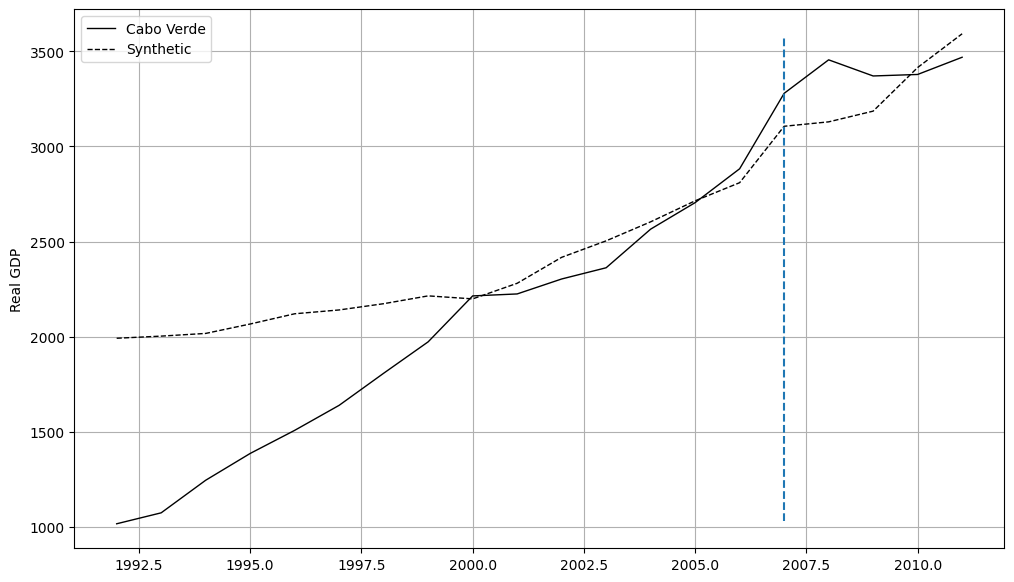

In [103]:
synth.path_plot(time_period=range(1992, 2012), treatment_time=2007)

## 2.2 2

In [89]:
weights = weights[weights>0]
a2 = pd.DataFrame(weights)
a2 = a2.rename(columns={'weights':'Cabo Verde'})
a2

,Cabo Verde
Bahrain,0.056
Bhutan,0.848
Iran,0.093
Palau,0.003


## 2.2 3

In [94]:
display('fit index', np.sqrt(synth.mspe()) / df[df['Country']=='Cabo Verde'][df['Year']<2007]['Real GDP'].std())

'fit index'

1.2437953918744902

## 2.2 4

In [70]:
weights

Bhutan    0.791
Iran      0.140
Palau     0.069
Name: weights, dtype: float64

In [72]:
# В статье больше, но я оставил эти, когда подгонял синтетическую группу
covaraites = ["share of agriculture","share of industry","investment rate","population density"]

In [73]:
bhutan  = df[df['Country'] =='Bhutan'][df['Year'].between(1992,2007)][covaraites].mean()
iran = df[df['Country'] =='Iran'][df['Year'].between(1992,2007)][covaraites].mean()
palau  = df[df['Country'] =='Palau'][df['Year'].between(1992,2007)][covaraites].mean()
syntetic  = ( df[df['Country'] =='Bhutan'][df['Year'].between(1992,2007)][covaraites].mean() * 0.791
 +df[df['Country'] =='Iran'][df['Year'].between(1992,2007)][covaraites].mean() * 0.140
 +df[df['Country'] =='Palau'][df['Year'].between(1992,2007)][covaraites].mean() * 0.069 )
cabo  = df[df['Country'] =='Cabo Verde'][df['Year'].between(1992,2007)][covaraites].mean()

In [74]:
a6 = pd.concat([syntetic, cabo,bhutan,iran,palau ], axis=1)
a6.columns = ['Syntetic', 'Cabo Verde (Исследовалась)', 'Bhutan', 'Iran', 'Palau']
a6 

,Syntetic,Cabo Verde (Исследовалась),Bhutan,Iran,Palau
share of agriculture,22.064237,11.104619,25.931581,9.224650,3.781231
share of industry,34.481343,23.160750,34.937912,42.095456,13.798409
investment rate,46.957286,34.292063,48.859813,37.870500,43.584125
population density,20.013399,104.496219,14.721306,40.016112,40.095512


## 2.2 5

In [75]:
dataprep = Dataprep(
    foo=df,
    predictors=["Real GDP"],
    predictors_op="mean",
    time_predictors_prior=range(1992, 2007),
    special_predictors=[
        ("share of agriculture", range(1992, 2007), "mean"),
        ("share of industry", [1992, 2007], "mean"),
        ("investment rate", [1992, 2007], "mean"),
        ("population density", [1992, 2007], "mean"),
    ],
    dependent="Real GDP",
    unit_variable="Country",
    time_variable="Year",
    treatment_identifier="Cabo Verde",
    controls_identifier=[
        'Bhutan', 'Iran', 'Palau'
    ],
    time_optimize_ssr=range(1992, 2007),
)

In [76]:
from pysyncon.utils import PlaceboTest
placebo_test = PlaceboTest()
placebo_test.fit(
    dataprep=dataprep,
    scm=synth,
    scm_options={"optim_method": "Nelder-Mead", "optim_initial": "equal"},
)

(1/3) Completed placebo test for Palau.
(2/3) Completed placebo test for Bhutan.
(3/3) Completed placebo test for Iran.
Calculating treated unit gaps.
Done.


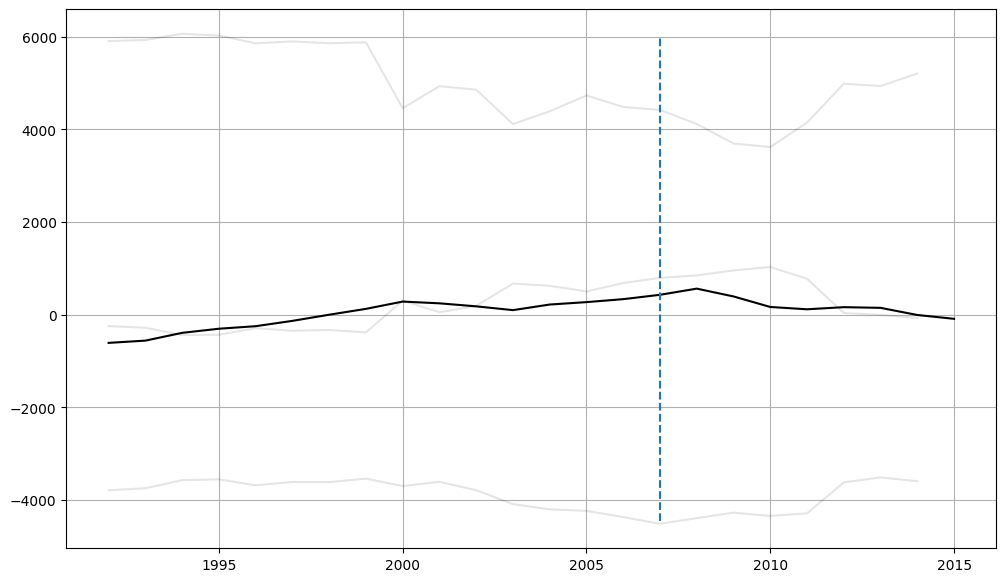

In [77]:
placebo_test.gaps_plot(
    time_period=range(1992, 2015), treatment_time=2007
)

## 2.2 6

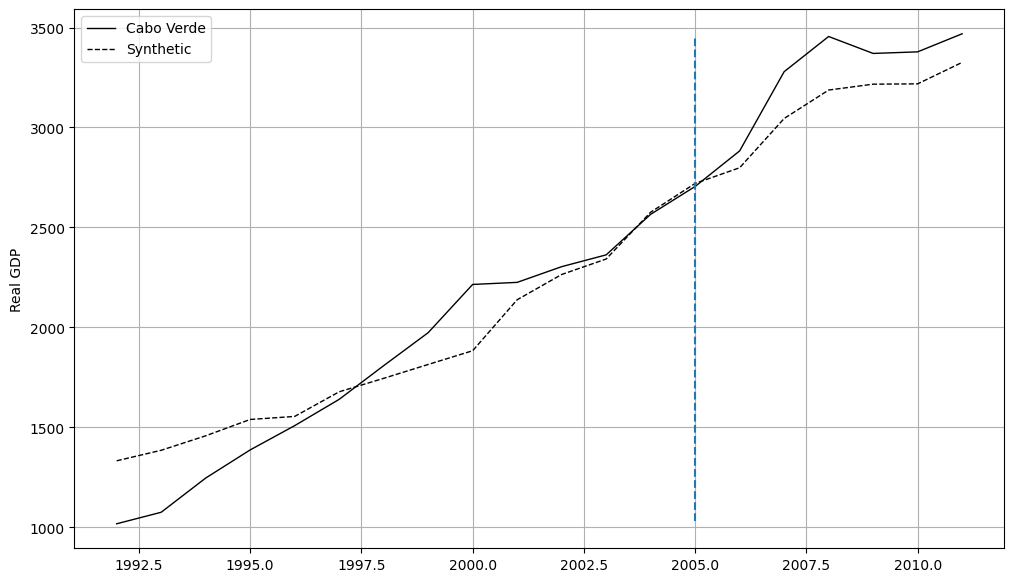

In [99]:
# Сделаем задание 1 , но поставив другой год
from pysyncon import Dataprep, Synth
dataprep = Dataprep(
    foo=df,
    predictors=["Real GDP"],
    predictors_op="mean",
    time_predictors_prior=range(1992, 2005),
    special_predictors=[
        ("share of agriculture", range(1992, 2005), "mean"),
        ("share of industry", [1992, 2005], "mean"),
        ("investment rate", [1992, 2005], "mean"),
        ("population density", [1992, 2005], "mean"),
    ],
    dependent="Real GDP",
    unit_variable="Country",
    time_variable="Year",
    treatment_identifier="Cabo Verde",
    controls_identifier=[
        'Bahrain', 'Barbados', 'Belize', 'Bhutan', 'Botswana',
       'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eritrea',
       'Eswatini', 'Fiji', 'Iran', 'Kiribati', 'Kuwait', 'Lebanon',
       'Libya', 'Marshall Islands', 'Mauritius', 'Micronesia',
       'Montenegro', 'Namibia', 'Oman', 'Palau', 'Qatar', 'Samoa',
       'Saudi Arabia', 'Sudan', 'Suriname', 'Syria', 'The Bahamas',
       'Timor-Leste', 'Tonga', 'Trinidad and Tobago', 'Turkmenistan',
       'Tuvalu', 'United Arab Emirates', 'Vanuatu'
    ],
    time_optimize_ssr=range(1992, 2005),
)
synth_train = Synth()
synth_train.fit(dataprep=dataprep)
synth = Synth()
synth.fit(dataprep=dataprep, custom_V=synth_train.V)

weights = synth.weights()
synth.path_plot(time_period=range(1992, 2012), treatment_time=2005)